In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns
from sklearn.model_selection import train_test_split

from scipy.optimize import leastsq

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.metrics import mean_squared_error
from sklearn import svm

In [ ]:
def info(df, head=True):
    print("Type: ", type(df))
    print("Shape: ", df.shape)
    print("Columns: ", df.columns)
    if head:
        display(df.head())
    else:
        display(df)

def corr_vis(df, features, meas='AVERAGEKWH_raw'):
    '''
    Displays a corrrelation chart for the  specified features in the edf
    '''
    ## Create a blank dataframe that calculates all the correlations to TOG
    vis = pd.DataFrame()
    vis['feature'] = features
    vis['spearman'] = [df[f].corr(df[meas], 'spearman') for f in features]
    #[print(str(features[f]) + ": " + str(spr['spearman'][f])) for f in range(len(features))]
    
    vis = vis.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    ax = sns.barplot(data=vis, y='feature', x='spearman', orient='h')
    
    ## Chart design
    ax.set(xlabel='correlation')
    ax.set(title='Correlation of all features to {meas}'.format(meas=meas)) 
    return vis

# Importing GeoDataFrames

California Counties and Boundarise sourced from https://data.ca.gov/dataset/ca-geographic-boundaries

In [ ]:
base = "/datasets/team-red-residential-energy-consumption/datasets/team-red-residential-energy-consumption/Data/"

In [ ]:
cleaned_monthly_with_zip_and_citis_fn = base + "cleaned_data/all-pge-with-nrel/transformed_pge-energy-consumption-with-nrel-solar_2013-2019_136968x35.shp"
zip_cities_monthly_pge_gdf = gpd.read_file(cleaned_monthly_with_zip_and_citis_fn)


In [ ]:
rename_mapper ={
    'TOTALCUSTO': 'TOTALCUSTO_raw',
    'TOTALKWH_r': 'TOTALKWH_raw',
    'AVERAGEKWH': 'AVERAGEKWH_raw',
    'TOTALTHERM': 'TOTALTHERM_raw',
    'AVERAGETHE': 'AVERAGETHERM_raw',
    'Temperatur': 'Temperature_raw', 
    'Solar Zeni': 'Solar_Zenith_Angle_raw',
    'TOTALCUS_1': 'TOTALCUS_std', 
    'TOTALKWH_s': 'TOTALKWH_std', 
    'AVERAGEK_1': 'AVERAGEKWH_std', 
    'TOTALTHE_1': 'TOTALTHERM_std', 
    'AVERAGET_1': 'AVERAGETHERM_std',
    'Wind Spe_1': 'Wind_Speed_std', 
    'Temperat_1': 'Temperature_std',
    'Solar Ze_1': 'Solar_Zenith_Angle_std', 
}
zip_cities_monthly_pge_gdf = zip_cities_monthly_pge_gdf.rename(rename_mapper, axis=1)
zip_cities_monthly_pge_gdf['Solar_Zenith_Angle_raw'] = pd.to_numeric(zip_cities_monthly_pge_gdf['Solar_Zenith_Angle_raw'])
zip_cities_monthly_pge_gdf['Temperature_raw'] = pd.to_numeric(zip_cities_monthly_pge_gdf['Temperature_raw'])

In [ ]:
info(zip_cities_monthly_pge_gdf)

Type:  <class 'geopandas.geodataframe.GeoDataFrame'>
Shape:  (136968, 36)
Columns:  Index(['zip', 'city', 'state', 'latitude', 'longitude', 'timezone', 'dst',
       'DATE', 'MONTH', 'YEAR', 'DAY', 'CUSTOMERCL', 'COMBINED',
       'TOTALCUSTO_raw', 'TOTALKWH_raw', 'AVERAGEKWH_raw', 'TOTALTHERM_raw',
       'AVERAGETHERM_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed',
       'Temperature_raw', 'Solar_Zenith_Angle_raw', 'TOTALCUS_std',
       'TOTALKWH_std', 'AVERAGEKWH_std', 'TOTALTHERM_std', 'AVERAGETHERM_std',
       'GHI_std', 'DHI_std', 'DNI_std', 'Wind_Speed_std', 'Temperature_std',
       'Solar_Zenith_Angle_std', 'geometry'],
      dtype='object')


,zip,city,state,latitude,longitude,timezone,dst,DATE,MONTH,YEAR,...,AVERAGEKWH_std,TOTALTHERM_std,AVERAGETHERM_std,GHI_std,DHI_std,DNI_std,Wind_Speed_std,Temperature_std,Solar_Zenith_Angle_std,geometry
0,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-01-01,1,2013,...,-0.590525,-0.46156,-0.348278,-1.198043,-1.373894,-0.709183,-1.894812,-2.255195,1.283431,POINT (-120.84510 39.17703)
1,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-02-01,2,2013,...,-0.590525,-0.46156,-0.348278,-0.621567,-0.990437,-0.041747,-1.837832,-1.881118,0.787489,POINT (-120.84510 39.17703)
2,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-03-01,3,2013,...,-0.590525,-0.46156,-0.348278,-0.341841,0.775179,-0.762886,-1.841878,-1.193114,0.089457,POINT (-120.84510 39.17703)
3,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-04-01,4,2013,...,-0.590525,-0.46156,-0.348278,0.639561,0.659686,0.529226,-1.828112,-0.713287,-0.643372,POINT (-120.84510 39.17703)
4,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-05-01,5,2013,...,0.278279,-0.46156,-0.348278,0.985208,0.972799,0.807632,-1.802339,-0.107015,-1.200288,POINT (-120.84510 39.17703)


### Sanity check geographic plots

#### California should look like California

#### PG&E dataset matches pg&e customers
PG&E service area reference: https://www.pge.com/mybusiness/customerservice/otherrequests/treetrimming/territory/

## Overlaying PG&E/NREL in Bay Area Only

Bay Area traditionally consists of [9 counties](https://wikitravel.org/en/Bay_Area_(California)).

<img src='https://wikitravel.org/upload/shared//thumb/b/bc/Bayarea_map.png/900px-Bayarea_map.png' style="width: 300px;">


We will define "Bay Area" as a box that encloses the following coordinates `(lat, long)`:

- South West corner: `(36.897966, -123.433313)`

- North East corner: `(38.593263, -121.381268)`

With these coordinates, we'll need to only consider data in the PG&E/NREL dataset that falls within this region.

In [ ]:
approximate_bay_area_center_lat = 39.5769252
approximate_bay_area_center_long = -122.2833322

## for subsetting the ca counties
bay_area_south_west_lat  = 36.897966    ## vertical
bay_area_south_west_long = -123.433313 ## horizontal
bay_area_north_east_lat  = 38.593263    ## vertical --> closer to north pole => higher values
bay_area_north_east_long = -121.381268 ## horizontal --> west long < east long. west is more negative

## for plotting boundaries
bay_area_limit_south_west_lat  = 36.897966    ## vertical
bay_area_limit_south_west_long = -123.75 ## horizontal
bay_area_limit_north_east_lat  = 38.9    ## vertical --> closer to north pole => higher values
bay_area_limit_north_east_long = -121.2 ## horizontal --> west long < east long. west is more negative


### Filtering Bay Area Only Data


#### Boxing the CA Counties Data

#### Boxing the PG&E/NREL Data

In [ ]:
zip_cities_monthly_pge_gdf.columns

Index(['zip', 'city', 'state', 'latitude', 'longitude', 'timezone', 'dst',
       'DATE', 'MONTH', 'YEAR', 'DAY', 'CUSTOMERCL', 'COMBINED',
       'TOTALCUSTO_raw', 'TOTALKWH_raw', 'AVERAGEKWH_raw', 'TOTALTHERM_raw',
       'AVERAGETHERM_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed',
       'Temperature_raw', 'Solar_Zenith_Angle_raw', 'TOTALCUS_std',
       'TOTALKWH_std', 'AVERAGEKWH_std', 'TOTALTHERM_std', 'AVERAGETHERM_std',
       'GHI_std', 'DHI_std', 'DNI_std', 'Wind_Speed_std', 'Temperature_std',
       'Solar_Zenith_Angle_std', 'geometry'],
      dtype='object')

In [ ]:
## subset south west
bay_area_monthly_pge_nrel = zip_cities_monthly_pge_gdf[ (bay_area_south_west_long <= zip_cities_monthly_pge_gdf['longitude']) & (bay_area_south_west_lat <= zip_cities_monthly_pge_gdf['latitude']) ]

## subst north east
bay_area_monthly_pge_nrel = bay_area_monthly_pge_nrel[ (bay_area_monthly_pge_nrel['longitude'] <= bay_area_north_east_long) & (bay_area_monthly_pge_nrel['latitude'] <= bay_area_north_east_lat) ]


In [ ]:
## Viewing how many measurements are the box
bay_area_monthly_pge_nrel.shape

(56683, 36)

In [ ]:
bay_area_monthly_pge_nrel.columns

Index(['zip', 'city', 'state', 'latitude', 'longitude', 'timezone', 'dst',
       'DATE', 'MONTH', 'YEAR', 'DAY', 'CUSTOMERCL', 'COMBINED',
       'TOTALCUSTO_raw', 'TOTALKWH_raw', 'AVERAGEKWH_raw', 'TOTALTHERM_raw',
       'AVERAGETHERM_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed',
       'Temperature_raw', 'Solar_Zenith_Angle_raw', 'TOTALCUS_std',
       'TOTALKWH_std', 'AVERAGEKWH_std', 'TOTALTHERM_std', 'AVERAGETHERM_std',
       'GHI_std', 'DHI_std', 'DNI_std', 'Wind_Speed_std', 'Temperature_std',
       'Solar_Zenith_Angle_std', 'geometry'],
      dtype='object')

In [ ]:
measurment_cols = ["MONTH",'TOTALCUSTO_raw', 'TOTALKWH_raw', 'AVERAGEKWH_raw', 'TOTALTHERM_raw',
       'AVERAGETHERM_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed',
       'Temperature_raw', 'Solar_Zenith_Angle_raw', 'TOTALCUS_std',
       'TOTALKWH_std', 'AVERAGEKWH_std', 'TOTALTHERM_std', 'AVERAGETHERM_std',
       'GHI_std', 'DHI_std', 'DNI_std', 'Wind_Speed_std', 'Temperature_std',
       'Solar_Zenith_Angle_std']

,feature,spearman
2,AVERAGEKWH_raw,-0.773815
13,AVERAGEKWH_std,-0.773815
1,TOTALKWH_raw,-0.773815
12,TOTALKWH_std,-0.773815
9,Temperature_raw,-0.186410
20,Temperature_std,-0.186410
16,GHI_std,-0.171452
18,DNI_std,-0.164958
7,DNI_raw,-0.162345
17,DHI_std,-0.128625


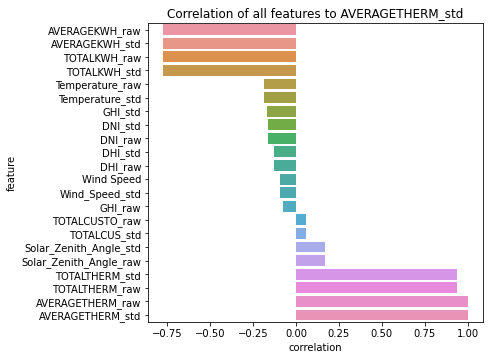

In [ ]:
corr_vis(bay_area_monthly_pge_nrel, measurment_cols, meas='AVERAGETHERM_std')

In [ ]:
X_cols = ['MONTH',
        'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed'    , 'Temperature_raw', 'Solar_Zenith_Angle_raw', 
        'GHI_std', 'DHI_std', 'DNI_std', 'Wind_Speed_std', 'Temperature_std', 'Solar_Zenith_Angle_std']
bay_area_monthly_elec_pge_nrel = bay_area_monthly_pge_nrel[bay_area_monthly_pge_nrel['TOTALTHERM_raw']==0]
elec_X_train = bay_area_monthly_elec_pge_nrel[X_cols]

## targetted_y can be changed to predict other values,
targetted_y = 'AVERAGEKWH_raw'
elec_Y_train = bay_area_monthly_elec_pge_nrel[targetted_y]


In [ ]:
## Trainv-validation split 
X_train, X_val, y_train, y_val = train_test_split(elec_X_train,elec_Y_train,test_size=0.2,
                                                  random_state=0)



### Simple Linear Regression

$$ \hat{\vec{y}} = \hat{\vec\beta}*\vec{x}$$

Coefficients in $ \hat{\vec\beta}$  are simply scalars that are fit to the best-fit line. That is, simply solving least squares

$$ \hat{\vec\beta} = (X^TX)^{-1}X^TY$$


In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train)

## apply model to training data
lm_train_pred = lm.predict(X_train)
lm_train_mse = mean_squared_error(y_true=y_train, y_pred=lm_train_pred)

## apply model to test data
lm_test_pred = lm.predict(X_val)
lm_test_mse = mean_squared_error(y_true=y_val, y_pred=lm_test_pred)
print("Training MSE", lm_train_mse)
print("Testing MSE", lm_test_mse)

Training MSE 62108.54563960087
Testing MSE 64468.0082181623


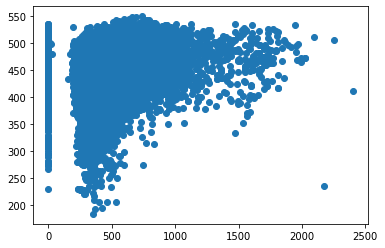

In [ ]:
plt.scatter(y_train, lm_train_pred)

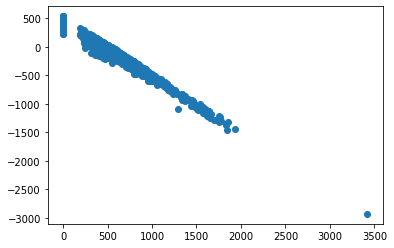

In [ ]:
plt.scatter(y_val, lm_test_pred-y_val)

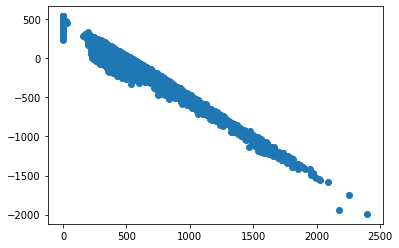

In [ ]:
plt.scatter(y_train, lm_train_pred-y_train)

In [ ]:
svr_regr = svm.SVR()
svr_regr.fit(X_train, y_train)

SVR()

In [ ]:
## apply model to training data
svr_train_pred = svr_regr.predict(X_train)
svr_train_mse = mean_squared_error(y_true=y_train, y_pred=svr_train_pred)

## apply model to test data
svr_test_pred = svr_regr.predict(X_val)
svr_test_mse = mean_squared_error(y_true=y_val, y_pred=svr_test_pred)
print("Training MSE", svr_train_mse)
print("Testing MSE", svr_test_mse)

Training MSE 61778.092673429004
Testing MSE 64263.70166864641


In [ ]:
sns.scatterplot(x=y_val)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c2f0e727-e6a4-4b2a-b180-a91c3a609ecf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>